# Project 3: Web APIs & NLP SubReddit Classification (Walmart & Costco)

---
Project notebook organisation:<br>
[1 - SubReddit Web Scrapping](./01_SubReddit_Web_Scrapping.ipynb)<br>
[2 - Exploratory Data Analysis and Preprocessing](./2_exploratory_data_analysis_and_preprocessing.ipynb)<br>
**3 - Classification Model and Recommendation** (current notebook)<br>
<br>

--- 
# Part 3: Classifcation Model and Recommendation

### Contents:
- [1. Import Libraries](#1.-Import-Libraries)
- [2. Load Datasets](#2.-Load-Datasets)
- [3. Modeling](#3.-Modeling)
- [4. Model Tuning & Production Model](#4.-Model-Tuning-&-Production-Model)
- [5. Sentiment Analysis & Business Summary](#5.-Sentiment-Analysis-&-Business-Summary)
- [6. Future Steps](#6.-Future-Steps)

In this part, I have attempted several classification models (e.g. Logistic Regression, KNearestNeighbor, Multinomial Naive Bayes, Random Tree Classifier) with the combination of utilizing CountVectorizer or TfidfVectorizer for subreddit classification.

I used F1 Score & AUC Score to compare among different model prediction, also it has a higher prediction than the baseline score of __50.5%__.The final production model that I chose was Logistic Regression with TfidfVectorizer, at a classification prediction rate of __93.3%__.

Lastly, I did Sentiment Analysis to aid for a better business recommendation to achieve our primary and scecondary objectives.

--- 

---

# 1. Import Libraries

---

In [1]:
#pip install textblob

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from wordcloud import WordCloud
from textblob import TextBlob
import spacy #spacy stopwords
from spacy.lang.en import English
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS,TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.pipeline import Pipeline

import datetime
import string
import time

%matplotlib inline

---

# 2. Load Datasets

---

In [3]:
# load cleaned corpus-result from part 2-EDA & Pre-processing
data_path = "../datasets/02_Exploratory_Data_Analysis_and_Preprocessing/"
df= pd.read_csv(data_path  + 'cleaned_posts_corpus.csv')

In [4]:
df.shape

(2881, 13)

In [5]:
df.head(3)

,subreddit,created_utc,id,title,selftext,upvote_ratio,score,num_comments,post_created_date,text,text_length,text_word_count,subreddit_type
0,walmart,1623481278,ny0t2k,the whole meat wall one night,that even possible,1.0,1,15,2021-06-12 15:01:18,the whole meat wall one night that even possible,51,9,0
1,walmart,1623477525,nxzwvb,cap overnight team leads,due unforseen circumstances was not able apply...,1.0,1,14,2021-06-12 13:58:45,cap overnight team lead due unforseen circumst...,494,82,0
2,walmart,1623476227,nxzkvz,pointing out after putting your two week notice,submitted week notice yesterday and points so...,1.0,1,11,2021-06-12 13:37:07,pointing out after putting your two week notic...,233,36,0


In [6]:
# We are only used 2 columns for Classification Model
df_model = df[['text', 'subreddit_type']]
df_model.head()

,text,subreddit_type
0,the whole meat wall one night that even possible,0
1,cap overnight team lead due unforseen circumst...,0
2,pointing out after putting your two week notic...,0
3,they drug test just got job local walmart truc...,0
4,there way limit hour availability online basic...,0


## 3. Modeling

In this section, I will explore 4 models. They are Naive Bayes, Random Forest, Logistic Regression and KNN. I will run each model twice, first time using CountVertorizer and second time using Term Frequency-Inverse Document Frequency (TF-IDF). I will provide a short explaination of each model and evaluate its performance success/downfalls.

__Naive Bayes Classifier__:
- it is a family of probabilistic algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of a feature.
- Bayes theorem calculates probability P(c|x) where c is the class of the possible outcomes and x is the given instance which has to be classified, representing some certain features.P(c|x) = P(x|c) * P(c) / P(x)
- Naive Bayes are mostly used in natural language processing (NLP) problems. Naive Bayes predict the tag of a text. They calculate the probability of each tag for a given text and then output the tag with the highest one.
- The advantages of Naive Bayes are it is easy to calculate probabilities and returns empirically accurate result.
- The disadvantage is the assumption of feature independence is unrealistic, especially in the case of text data. The predicted probabilites could be not so good.

__The Random Forest (RF) classifiers__
- It is suitable for dealing with the high dimensional noisy data in text classification. An RF model comprises a set of decision trees each of which is trained using random subsets of features. 
- It requires much computational power as well as resources as it builds numerous trees to combine their outputs. 
- It also requires much time for training as it combines a lot of decision trees to determine the class.
- Due to the ensemble of decision trees, it also suffers interpretability and fails to determine the significance of each variable.

We also attempted it and see how well it for our subreddit classification.

__Logistic Regression__
- It is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.
- Logistic regression uses the logit link to bend our line of best fit. This allows us to predict between 0 and 1 for any value of inputs. 
    
#### $$\text{logit}\left(P(Y = 1)\right) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$ ####

- The advantage of logistic regression are the coefficients are interpretable and it shares similar properties to linear regression. 
- The disadvantage is the assumption of linearity between the dependent variable and independent variables. Logistic Regression requires average or no mulitcollinearity between independent variables. 

__K-Nearest-Neighbor__

- The k-nearest neighbors algorithm (k-NN) is a non-parametric method. In k-NN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.
- The advantage of KNN is it has no training period. KNN is called Lazy Learner (Instance based learning). It does not learn anything in the training period. It does not derive any discriminative function from the training data. In other words, there is no training period for it. It stores the training dataset and learns from it only at the time of making real time predictions. This makes the KNN algorithm much faster than other algorithms that require training e.g. SVM, Linear Regression etc. 
- Since the KNN algorithm requires no training before making predictions, new data can be added seamlessly which will not impact the accuracy of the algorithm. 
- KNN is very easy to implement. There are only two parameters required to implement KNN i.e. the value of K and the distance function (e.g. Euclidean or Manhattan etc.)
- The disadvantage of KNN is it does not work well with large dataset. In large datasets, the cost of calculating the distance between the new point and each existing points is huge which degrades the performance of the algorithm.
- The KNN algorithm doesn't work well with high dimensional data because with large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension.
- There is also no parameters for interpretation of coefficient. 

### 3.1 Create Model Feature & Train-Test Split

In [7]:
X = df_model['text']
y = df_model['subreddit_type']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   random_state = 42,
                                                   test_size=0.33,
                                                   shuffle = True,
                                                   stratify = y)

### Comments:

A train test split will be utilized to train the model and see how the model performs with 'unseen' (test) inputs.

### 3.2 Baseline model

In [9]:
y.value_counts(normalize = True)

1    0.50538
0    0.49462
Name: subreddit_type, dtype: float64

### Comments:

The baseline accuracy is the percentage of the majority class-Costco which is 50.5%. It serves as the benchmark for my model to beat.

### 3.3 Model Evaluation Metrics

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known, and by looking at the ROC curve and we can determine whether our ROC curve is good or not by looking at AUC (Area Under the Curve). 

These are 4 parameters for a confusion matrix: True Positives (TP),True Negatives (TN),False Positives (FP) & False Negatives (FN).False positives and false negatives, these values occur when your actual class contradicts with the predicted class.
With these 4 parameters We can calculate Accuracy, Precision, Recall and F1 score.

Accuracy= TP+TN/TP+FP+FN+TN - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. 

Precision=TP/TP+FP - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all posts that labeled as Walmart or Costco, how many actually corrected labeled? High precision relates to the low false positive rate. 

Recall (Sensitivity)= TP/TP+FN - Recall is the ratio of correctly predicted positive observations to the all observations in actual class.

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 

**I will use F1 Score as my different model evaluations metric**

### 3.4 Stopwords

Same as what I used in Exploratory Data Analysis portion, I used the same Stopwords list with the combination of stopwords from 3 different libraries: nltk, spacy & sklearn.

In [10]:
def get_stopwords():
    nltk_stopwords = set(stopwords.words('english'))
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    sklearn_stopwords = set(ENGLISH_STOP_WORDS)

    all_stopwords = set()
    all_stopwords |= spacy_stopwords
    all_stopwords |= nltk_stopwords
    all_stopwords |= sklearn_stopwords

    return all_stopwords 

all_stopwords = get_stopwords()

In [11]:
# Update stopwords as they repeated with high frequency in the text but not much meaning 
all_stopwords.update(['www', 'costco', 'wa', 'doe','ha','know',
                      'told','feel','like','tikok','com', 'webp', 'amp', 'html', 'her','walmart', "wal","mart"])

In [12]:
all_stopwords = list(all_stopwords)

### 3.5 CountVectorize

The count vectorizer has been used before in the exploratory data analysis portion because it examines a corpus, which is a collection of documents, and returns a vectorized array of the most prominent words and the count of those words accross each document. It is a necessary step in order to create an array for classification, because we cannot simply stick in words of text into classification model.

#### 3.5.1 Navie Bayes 

In [13]:
pipe = Pipeline([
    ('cvec', CountVectorizer(token_pattern=r'[a-zA-Z]{2,}', analyzer = "word", stop_words=all_stopwords)),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3, 4, 6],
    'cvec__max_df': [.03, .05, .1,.2, 0.8, 0.85, 0.9],
    'cvec__ngram_range': [(1,1),(1,2),(2,3)]
}

rscv = RandomizedSearchCV(pipe, # what object are we optimizing?
                  param_distributions =pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [14]:
# Fit GridSearch to training data.
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(stop_words=['but',
                                                                          'alone',
                                                                          'down',
                                                                          'ca',
                                                                          'hence',
                                                                          'know',
                                                                          'all',
                                                                          'none',
                                                                          'seem',
                                                                          'can',
                                                                          '‘d',
                        

In [15]:
print(f'MultinomialNB with CountVectorize-train score: {round(rscv.best_score_,3)}')
print(f'MultinomialNB with CountVectorize-test score: {round(rscv.score(X_test, y_test),3)}')
print(f'MultinomialNB by RandomizedGridSearchCV best params: {rscv.best_params_}')

MultinomialNB with CountVectorize-train score: 0.869
MultinomialNB with CountVectorize-test score: 0.858
MultinomialNB by RandomizedGridSearchCV best params: {'cvec__ngram_range': (1, 1), 'cvec__min_df': 2, 'cvec__max_features': 4000, 'cvec__max_df': 0.1}


In [16]:
report = classification_report(y_test,rscv.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
print(class_table)

           precision    recall  f1-score     support
Predict 0   0.831683  0.893617  0.861538  470.000000
Predict 1   0.887892  0.823285  0.854369  481.000000
accuracy    0.858044  0.858044  0.858044    0.858044


### Comments:

- The model fits quite well, has a high mean accuracy score of 0.869 and 0.858 for test score.
- The model also has a higher recall-0.89 for Costco. (the % of positive cases model been labeled)
- The model has a higher precision-0.88 for Walmart. (the % of the model prediction is correct)

#### 3.5.2 Random Forest

In [17]:
pipe = Pipeline([
    ('cvec', CountVectorizer(token_pattern=r'[a-zA-Z]{2,}', analyzer = "word", stop_words=all_stopwords)),
    ('rf', RandomForestClassifier(random_state = 42))
])

pipe_params = {
    'rf__n_estimators':[100, 150, 200],
    'rf__max_depth': [None, 50, 100],
    'rf__max_features': ['auto', 10, 20, 50],
    'rf__min_samples_split':[2, 25, 40, 50, 70],
    'rf__min_samples_leaf': [1],
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3, 4, 6],
    'cvec__max_df': [.03, .05, .1,.2, 0.8, 0.85, 0.9],
    'cvec__ngram_range': [(1,1),(1,2),(2,3)]
}

rscv = RandomizedSearchCV(pipe, # what object are we optimizing?
                  param_distributions=pipe_params, # what parameters values are we searching?
                  n_iter = 50,
                  cv=5) # 5-fold cross-validation.

In [18]:
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(stop_words=['but',
                                                                          'alone',
                                                                          'down',
                                                                          'ca',
                                                                          'hence',
                                                                          'know',
                                                                          'all',
                                                                          'none',
                                                                          'seem',
                                                                          'can',
                                                                          '‘d',
                        

In [19]:
print(f'RandomForest with CountVectorize-train score: {round(rscv.best_score_,3)}')
print(f'RandomForest with CountVectorize-test score: {round(rscv.score(X_test, y_test),3)}')
print(f'RandomForest by RandomizedGridSearchCV best params: {rscv.best_params_}')

RandomForest with CountVectorize-train score: 0.837
RandomForest with CountVectorize-test score: 0.842
RandomForest by RandomizedGridSearchCV best params: {'rf__n_estimators': 200, 'rf__min_samples_split': 50, 'rf__min_samples_leaf': 1, 'rf__max_features': 10, 'rf__max_depth': 100, 'cvec__ngram_range': (1, 2), 'cvec__min_df': 4, 'cvec__max_features': 4000, 'cvec__max_df': 0.85}


In [20]:
report = classification_report(y_test,rscv.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
print(class_table)

           precision    recall  f1-score     support
Predict 0   0.840426  0.840426  0.840426  470.000000
Predict 1   0.844075  0.844075  0.844075  481.000000
accuracy    0.842271  0.842271  0.842271    0.842271


### Comments:

- The model fits quite well, has a high mean accuracy score of 0.837 and 0.842 for test score. But it's slightly lower than MultinomialNB model.
- The model also has a higher recall-0.844 for Walmart. (the % of positive cases model been labeled)
- The model has a higher precision-0.844 for Walmart. (the % of the model prediction is correct)

#### 3.5.3 Logistic Regression

In [21]:
pipe = Pipeline([
    ('cvec', CountVectorizer(token_pattern=r'[a-zA-Z]{2,}', analyzer = "word", stop_words=all_stopwords)),
    ('lr', LogisticRegression(solver='lbfgs')) # For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss
])

pipe_params = {
    'cvec__max_features': [1_000,2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [.8, .85,.9],
    'cvec__ngram_range': [(1,1),(1,2),(2,3)]
}

rscv = RandomizedSearchCV(pipe, # what object are we optimizing?
                  param_distributions =pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=-1) 

In [22]:
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(stop_words=['but',
                                                                          'alone',
                                                                          'down',
                                                                          'ca',
                                                                          'hence',
                                                                          'know',
                                                                          'all',
                                                                          'none',
                                                                          'seem',
                                                                          'can',
                                                                          '‘d',
                        

In [23]:
print(f'LogisticsRegression with CountVectorize-train score: {round(rscv.best_score_,3)}')
print(f'LogisticsRegression with CountVectorize-test score: {round(rscv.score(X_test, y_test),3)}')
print(f'LogisticsRegression by RandomizedGridSearchCV best params: {rscv.best_params_}')

LogisticsRegression with CountVectorize-train score: 0.848
LogisticsRegression with CountVectorize-test score: 0.825
LogisticsRegression by RandomizedGridSearchCV best params: {'cvec__ngram_range': (1, 1), 'cvec__min_df': 2, 'cvec__max_features': 4000, 'cvec__max_df': 0.9}


In [24]:
report = classification_report(y_test,rscv.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
print(class_table)

           precision    recall  f1-score     support
Predict 0   0.816667  0.834043  0.825263  470.000000
Predict 1   0.834395  0.817048  0.825630  481.000000
accuracy    0.825447  0.825447  0.825447    0.825447


### Comments:

- The model fits quite well, has a high mean accuracy score of 0.848 and 0.824 for test score. But it's slightly lower than MultinomialNB model, and similar to Random Forest model.
- The model also has a higher recall-0.83 for Costco. (the % of positive cases model been labeled)
- The model has a higher precision-0.83 for Walmart. (the % of the model prediction is correct)

#### 3.5.4 KNN

In [25]:
pipe = Pipeline([
    ('cvec', CountVectorizer(token_pattern=r'[a-zA-Z]{2,}', analyzer = "word", stop_words=all_stopwords)),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'cvec__max_features': [1_000,2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [.5, .6, .7, .8],
    'cvec__ngram_range': [(1,1),(1,2),(2,3)],
    'knn__n_neighbors': [10, 25],
    'knn__weights':['uniform','distance']
}

rscv = RandomizedSearchCV(pipe, # what object are we optimizing?
                  param_distributions =pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=-1) 

In [26]:
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(stop_words=['but',
                                                                          'alone',
                                                                          'down',
                                                                          'ca',
                                                                          'hence',
                                                                          'know',
                                                                          'all',
                                                                          'none',
                                                                          'seem',
                                                                          'can',
                                                                          '‘d',
                        

In [27]:
print(f'KNN with CountVectorize-train score: {round(rscv.best_score_,3)}')
print(f'KNN with CountVectorize-test score: {round(rscv.score(X_test, y_test),3)}')
print(f'KNN by RandomizedGridSearchCV best params: {rscv.best_params_}')

KNN with CountVectorize-train score: 0.701
KNN with CountVectorize-test score: 0.723
KNN by RandomizedGridSearchCV best params: {'knn__weights': 'uniform', 'knn__n_neighbors': 10, 'cvec__ngram_range': (1, 2), 'cvec__min_df': 2, 'cvec__max_features': 2000, 'cvec__max_df': 0.5}


In [28]:
report = classification_report(y_test,rscv.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
print(class_table)

           precision    recall  f1-score     support
Predict 0   0.763359  0.638298  0.695249  470.000000
Predict 1   0.695341  0.806653  0.746872  481.000000
accuracy    0.723449  0.723449  0.723449    0.723449


### Comments:

- The model fits very bad, seems there's high bias and low variance been captured, it has a low mean accuracy score of 0.701 and 0.723 for test score. It's the lowest score model among of all 4 models. (as all other models fitted quite well, I will assume it's not the data issue)
- The model also has a higher recall-0.8 for Walmart. (the % of positive cases model been labeled)
- The model has a higher precision-0.76 for Costco. (the % of the model prediction is correct)

### Model Summary with Count Vectorizer:

Summary of 4 model predictions:

|Model|Train Score|Test Score|Accuracy|F1 Score|
|---|---|---|---|---|
|Navie Bayes          |0.869      |0.858|0.858|0.861
|Random Forest        |0.837      |0.842|0.842|0.844
|Logistic Regression  |0.848      |0.825|0.825|0.825
|KNN |0.702|0.723|0.723|0.74

- We can see that MultinomialNB model performed the best among these 4 models. It has the highest mean accuracy score (0.858).
- From the time spent for GridSearch, Logistic Regression and KNN spent the least time while Random Forest spent the most time and required a higher computing power if there are large dataset.
- It's quite surprised KNN didnot perform so well that it has only 0.711 mean accuracy score, it might because of difficult to calculate the distance between each dimension.

### 3.6  Term Frequency-Inverse Document Frequency (TF-IDF)

#### 3.6.1 Navie Bayes

In [29]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(token_pattern=r'[a-zA-Z]{2,}', analyzer = "word", stop_words=all_stopwords)),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfidf__max_features': [1_000,2_000, 3_000, 4_000, 5_000],
    'tfidf__min_df': [2, 4, 6],
    'tfidf__max_df': [.03, .05, .1,.2],
    'tfidf__ngram_range': [(1,1),(1,2),(2,3)]
}

rscv = RandomizedSearchCV(pipe, # what object are we optimizing?
                  param_distributions =pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [30]:
# Fit GridSearch to training data.
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words=['but',
                                                                          'alone',
                                                                          'down',
                                                                          'ca',
                                                                          'hence',
                                                                          'know',
                                                                          'all',
                                                                          'none',
                                                                          'seem',
                                                                          'can',
                                                                          '‘d',
                       

In [31]:
print(f'MultinomialNB with Ffidfvectorizer-train score: {round(rscv.best_score_,3)}')
print(f'MultinomialNB with Ffidfvectorizer-test score: {round(rscv.score(X_test, y_test),3)}')
print(f'MultinomialNB by RandomizedGridSearchCV best params: {rscv.best_params_}')

MultinomialNB with Ffidfvectorizer-train score: 0.866
MultinomialNB with Ffidfvectorizer-test score: 0.858
MultinomialNB by RandomizedGridSearchCV best params: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_features': 5000, 'tfidf__max_df': 0.2}


In [32]:
report = classification_report(y_test,rscv.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
print(class_table)

           precision    recall  f1-score     support
Predict 0   0.834331  0.889362  0.860968  470.000000
Predict 1   0.884444  0.827443  0.854995  481.000000
accuracy    0.858044  0.858044  0.858044    0.858044


### Comments:

- The model fits quite well, has a high mean accuracy score of 0.866 and 0.858 for test score. It has a slightly better test score compared to same model with CountVectorizer. 
- The model also has a higher recall-0.88 for Costco. (the % of positive cases model been labeled)
- The model has a higher precision-0.88 for Walmart. (the % of the model prediction is correct)

#### 3.6.2 Random Forest

In [33]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(token_pattern=r'[a-zA-Z]{2,}', analyzer = "word", stop_words=all_stopwords)),
    ('rf', RandomForestClassifier(random_state = 42))
])

pipe_params = {
    'rf__n_estimators':[100, 150, 200],
    'rf__max_depth': [None, 50, 100],
    'rf__max_features': ['auto', 10, 20, 50],
    'rf__min_samples_split':[2, 25, 40, 50, 70],
    'rf__min_samples_leaf': [1],
    'tfidf__max_features': [1_000, 2_000, 3_000, 4_000, 5_000],
    'tfidf__min_df': [2, 3, 4, 6],
    'tfidf__max_df': [.03, .05, .1,.2, 0.8, 0.85, 0.9],
    'tfidf__ngram_range': [(1,1),(1,2),(2,3)]
}

rscv = RandomizedSearchCV(pipe, # what object are we optimizing?
                  param_distributions=pipe_params, # what parameters values are we searching?
                  n_iter = 50,
                  cv=5) # 5-fold cross-validation.

In [34]:
# Fit GridSearch to training data.
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words=['but',
                                                                          'alone',
                                                                          'down',
                                                                          'ca',
                                                                          'hence',
                                                                          'know',
                                                                          'all',
                                                                          'none',
                                                                          'seem',
                                                                          'can',
                                                                          '‘d',
                       

In [35]:
print(f'RandomForest with Ffidfvectorizer-train score: {round(rscv.best_score_,3)}')
print(f'RandomForest with Ffidfvectorizer-test score: {round(rscv.score(X_test, y_test),3)}')
print(f'RandomForest by RandomizedGridSearchCV best params: {rscv.best_params_}')

RandomForest with Ffidfvectorizer-train score: 0.842
RandomForest with Ffidfvectorizer-test score: 0.825
RandomForest by RandomizedGridSearchCV best params: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_features': 4000, 'tfidf__max_df': 0.8, 'rf__n_estimators': 150, 'rf__min_samples_split': 25, 'rf__min_samples_leaf': 1, 'rf__max_features': 10, 'rf__max_depth': 100}


In [36]:
report = classification_report(y_test,rscv.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
print(class_table)

           precision    recall  f1-score     support
Predict 0   0.837778  0.802128  0.819565  470.000000
Predict 1   0.814371  0.848233  0.830957  481.000000
accuracy    0.825447  0.825447  0.825447    0.825447


### Comments:

- The model fits quite well, has a high mean accuracy score of 0.842 and 0.825 for test score. But it's slightly lower than same model with CountVectorizer.
- The model also has a higher recall-0.837 for Walmart. (the % of positive cases model been labeled)
- The model has a higher precision-0.848 for Walmart. (the % of the model prediction is correct)

#### 3.6.3 Logistic Regression

In [37]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(token_pattern=r'[a-zA-Z]{2,}', analyzer = "word", stop_words=all_stopwords)),
    ('lr', LogisticRegression(solver='lbfgs')) # For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss
])

pipe_params = {
    'tfidf__max_features': [1_000,2_000, 3_000, 4_000, 5_000],
    'tfidf__min_df': [2,3, 4, 6],
    'tfidf__max_df': [.8, .85,.9],
    'tfidf__ngram_range': [(1,1),(1,2),(2,3)],
}

rscv = RandomizedSearchCV(pipe, # what object are we optimizing?
                  param_distributions =pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=-1) 

In [38]:
# Fit GridSearch to training data.
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words=['but',
                                                                          'alone',
                                                                          'down',
                                                                          'ca',
                                                                          'hence',
                                                                          'know',
                                                                          'all',
                                                                          'none',
                                                                          'seem',
                                                                          'can',
                                                                          '‘d',
                       

In [39]:
print(f'LogisticsRegression with Ffidfvectorizer-train score: {round(rscv.best_score_,3)}')
print(f'LogisticsRegression with Ffidfvectorizer-test score: {round(rscv.score(X_test, y_test),3)}')
print(f'LogisticsRegression by RandomizedGridSearchCV best params: {rscv.best_params_}')

LogisticsRegression with Ffidfvectorizer-train score: 0.856
LogisticsRegression with Ffidfvectorizer-test score: 0.849
LogisticsRegression by RandomizedGridSearchCV best params: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_features': 2000, 'tfidf__max_df': 0.8}


In [40]:
report = classification_report(y_test,rscv.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
print(class_table)

           precision    recall  f1-score    support
Predict 0   0.843882  0.851064  0.847458  470.00000
Predict 1   0.853249  0.846154  0.849687  481.00000
accuracy    0.848580  0.848580  0.848580    0.84858


### Comments:

- The model fits quite well, has a high mean accuracy score of 0.856 and 0.849 for test score. But it's slightly lower score compared to same model using Count Vectorizer in unseen test data.
- The model also has a higher recall-0.85 for Walmart. (the % of positive cases model been labeled)
- The model has a higher precision-0.85 for Walmart. (the % of the model prediction is correct)

#### 3.5.5 KNN

In [41]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(token_pattern=r'[a-zA-Z]{2,}', analyzer = "word", stop_words=all_stopwords)),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'tfidf__max_features': [1_000,2_000, 3_000, 4_000, 5_000],
    'tfidf__min_df': [2, 3, 4, 6],
    'tfidf__max_df': [.5, .6, .7, .8,.95],
    'tfidf__ngram_range': [(1,1),(1,2),(2,3)],
    'knn__n_neighbors': [5, 6],
    'knn__weights':['uniform','distance']
}

rscv = RandomizedSearchCV(pipe, # what object are we optimizing?
                  param_distributions =pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  n_jobs=-1) 

In [42]:
# Fit GridSearch to training data.
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words=['but',
                                                                          'alone',
                                                                          'down',
                                                                          'ca',
                                                                          'hence',
                                                                          'know',
                                                                          'all',
                                                                          'none',
                                                                          'seem',
                                                                          'can',
                                                                          '‘d',
                       

In [67]:
print(f'KNN with Ffidfvectorizer-train score: {round(rscv.best_score_,3)}')
print(f'KNN with Ffidfvectorizer-test score: {round(rscv.score(X_test, y_test),3)}')
print(f'KNN by RandomizedGridSearchCV best params: {rscv.best_params_}')

KNN with Ffidfvectorizer-train score: 0.808
KNN with Ffidfvectorizer-test score: 0.797
KNN by RandomizedGridSearchCV best params: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 3, 'tfidf__max_features': 5000, 'tfidf__max_df': 0.5, 'knn__weights': 'uniform', 'knn__n_neighbors': 6}


In [44]:
report = classification_report(y_test,rscv.best_estimator_.predict(X_test), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
print(class_table)

           precision    recall  f1-score     support
Predict 0   0.747764  0.889362  0.812439  470.000000
Predict 1   0.867347  0.706861  0.778923  481.000000
accuracy    0.797056  0.797056  0.797056    0.797056


### Comments:

- The model fits well, it has a slightly lower mean accuracy score of 0.808 and 0.779 for test score. It's the lowest score model among of all 4 models. (as all other models fitted quite well, I will assume it's not the data issue)
- The model also has a higher recall-0.88 for Costco. (the % of positive cases model been labeled)
- The model has a higher precision-0.86 for Walmart. (the % of the model prediction is correct)

### Model Summary with TfidF Vectorizer:

Summary of 4 model predictions:

|Model|Train Score|Test Score|Accuracy|F1 Score|
|---|---|---|---|---|
|Navie Bayes          |0.866      |0.858|0.858|0.86
|Random Forest        |0.842      |0.825|0.825|0.83
|Logistic Regression  |0.856      |0.849|0.849|0.85
|KNN                  |0.808      |0.797|0.797|0.81

- TF-IDF Vectorizer overall improves the model compared to CountVectorizer. (KNN improves a lot while Logistics Regression also has slightly improved)
- We can see that both MultinomialNB model & Logistic Regression Model performed the better among these 4 models. They have the highest accuracy Score (0.858) and (0.849).
- From the time spent for GridSearch, Logistic Regression and KNN spent the least time while Random Forest spent the most time and required a higher computing power if there are large dataset.

## 4. Model Tuning & Production Model

I will choose the best model derived from above (Logistic Regression with TfidfVectorizer) to conduct further tuning. 

This includes a histogram plot to display distribution of both the true and predicted value, and a Receiver Operation Characteristic to illustrate the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

In [45]:
# use the best parameters afte GridSearch
tfidf = TfidfVectorizer(token_pattern=r'[a-zA-Z]{2,}',
                        analyzer = "word",
                        stop_words=all_stopwords,
                        max_df=0.85,
                        min_df=3,
                        ngram_range=(1,2),
                        max_features=4000)

In [46]:
X_train_c = tfidf.fit_transform(X_train)
X_test_c = tfidf.transform(X_test)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train_c, y_train)

report = classification_report(y_test, lr.predict(X_test_c), target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose().drop(['macro avg','weighted avg'],axis=0)
class_table

,precision,recall,f1-score,support
Predict 0,0.849257,0.851064,0.850159,470.000000
Predict 1,0.854167,0.852391,0.853278,481.000000
accuracy,0.851735,0.851735,0.851735,0.851735


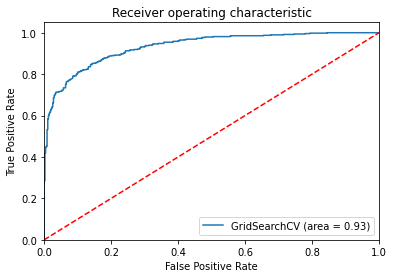

In [47]:
probs = lr.predict_proba(X_test_c)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [48]:
print(f"Best Model-Logistic Regression + TfidfVectorizer with ROC AUC is: {round(roc_auc,3)}")

Best Model-Logistic Regression + TfidfVectorizer with ROC AUC is: 0.933


In [49]:
X_train_tfidf_df_best = pd.DataFrame(X_train_c.todense(), columns=tfidf.get_feature_names())

In [50]:
#to get the coefficients df to plot 
coefficients_df = pd.DataFrame(zip(X_train_tfidf_df_best.columns, np.transpose(lr.coef_)), columns=['features', 'coef'])
coefficients_df = coefficients_df.sort_values(by='coef')
coefficients_df['coef'] = coefficients_df['coef'].astype(float)

In [69]:
#getting top 10 and bottom 10 which is best costco and best walmart 
coefficients_df_plot = pd.concat([coefficients_df[0:10],coefficients_df[-10:]])
coefficients_df_plot = coefficients_df_plot.sort_values(by='coef', ascending=False)

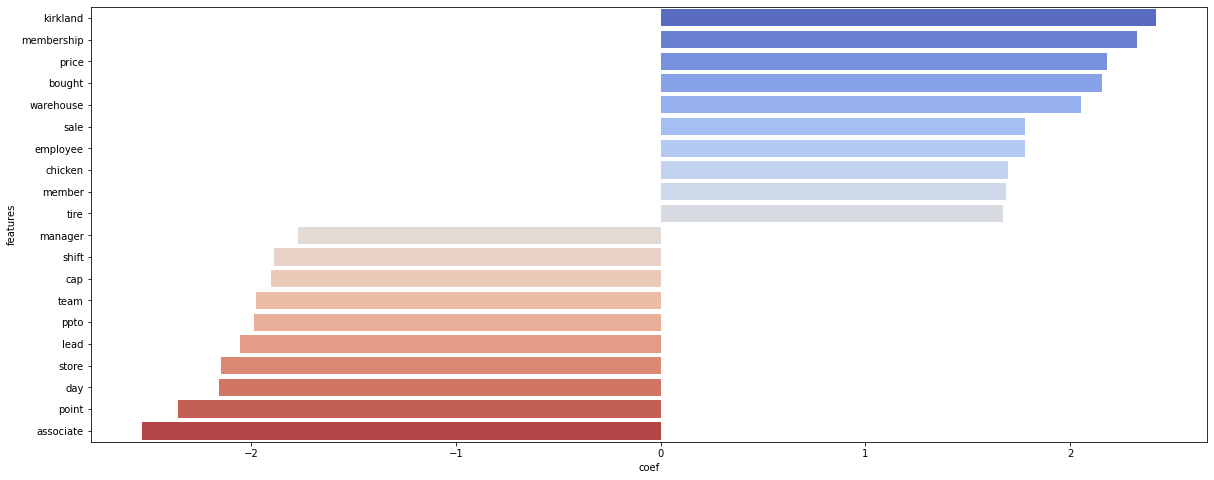

In [52]:
#plot graph 
plt.figure(figsize=(20,8))
sns.barplot(y=coefficients_df_plot['features'], x= coefficients_df_plot['coef'], data=coefficients_df_plot,orient='h',palette = 'coolwarm');

In [73]:
lr_coef_value = pd.DataFrame(data=lr.coef_.T, index=tfidf.get_feature_names())
lr_coef_value.columns = ['coef']
lr_coef_value['exp_coef'] = np.exp(lr_coef_value['coef'])
lr_coef_value.sort_values(by='exp_coef', ascending=False).head(10)

,coef,exp_coef
kirkland,2.419501,11.240253
membership,2.325137,10.228084
price,2.177972,8.828382
bought,2.156362,8.639646
warehouse,2.051923,7.782854
sale,1.781042,5.936040
employee,1.776873,5.911340
chicken,1.694178,5.442168
member,1.684294,5.388644
tire,1.669667,5.310400


### Justification for picking Logistic Regression TF-IDF & Interpretation of Model

1. TF-IDF penalize common words and give rare words more influence. This is relevant to our problem statement, Walmart posts and Costco posts tends to use different terms. For example, Walmart post commonly use the word "team lead", "Covid Vaccine", "Covid Shot" because there are lots of complaints, criticism from various groups and individuals.On the other hand, Costco post might commonly find the word "food court" or "Kirland signature" because that is a popular of Costco brand and service. Therefore, penalize common words and giving more influence to rare words would help us in our classification problem. 

2. Comparing the model scores of CountVectorizer and TfidfVectorizer, in all instances models under TfidfVectorizer scores better. 

3. Why Logistic Regression? Logistic Regression gives a high mean accuracy score for both training data (0.856) and test data (0.849). This means that the model generalises well and scores well on unseen data, though it's not the model with higest score. It also scores much better than the baseline score.  
 
4. Logistic Regression allows me to interpret model coefficients as indicators of feature importance. The interpretation of coefficients allows us to make useful recommendations for our problem statement.  

5. Logistic Regression also has some limiations, for instance it assumes independence of independent Variables and the independent variables X1, . . . , Xm are linearly related to the logit of the probability. These are assumations however it may not always be the case. Nonetheless, for our problem statement, logistic regression is an useful model. 

## 5. Sentiment Analysis & Business Summary

#### Research & Sentiment Analysis

From the WordCloud and Top words visualization, also the high coefficients ploted, We are able to identify what subreddit users think of both supermarkets, but it is not sufficient for us to know where positive feedback will continue to be reinforced and adopted while negative feedback can be addressed and prevented.

We did Sentiment Analysis in aid for a better business recommendation to answer our problem statement and 2 objectives:

**Primary Objective**: 
To enhance our understanding of Walmart's social media image on reddit so as to introduce strategy for improvement.

**Secondary Objective**: 
To identify what subreddit users think of both supermarkets, where positive feedback will continue to be reinforced and adopted while negative feedback can be addressed and prevented.

In [53]:
df.head(3)

,subreddit,created_utc,id,title,selftext,upvote_ratio,score,num_comments,post_created_date,text,text_length,text_word_count,subreddit_type
0,walmart,1623481278,ny0t2k,the whole meat wall one night,that even possible,1.0,1,15,2021-06-12 15:01:18,the whole meat wall one night that even possible,51,9,0
1,walmart,1623477525,nxzwvb,cap overnight team leads,due unforseen circumstances was not able apply...,1.0,1,14,2021-06-12 13:58:45,cap overnight team lead due unforseen circumst...,494,82,0
2,walmart,1623476227,nxzkvz,pointing out after putting your two week notice,submitted week notice yesterday and points so...,1.0,1,11,2021-06-12 13:37:07,pointing out after putting your two week notic...,233,36,0


In [54]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['polularity'] = df['text'].apply(pol)
df['subjectivity'] = df['text'].apply(sub)

In [55]:
# Creating function for calculating positive, negative and neutral
# More than 1 --> Positive, equal to 0 --> neutral and less than 0 --> Negative
def ratio(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1

In [56]:
df['analysis'] = df['polularity'].apply(ratio)

In [57]:
df[['subreddit', 'text', 'analysis']][:5]

,subreddit,text,analysis
0,walmart,the whole meat wall one night that even possible,1
1,walmart,cap overnight team lead due unforseen circumst...,1
2,walmart,pointing out after putting your two week notic...,0
3,walmart,they drug test just got job local walmart truc...,-1
4,walmart,there way limit hour availability online basic...,-1


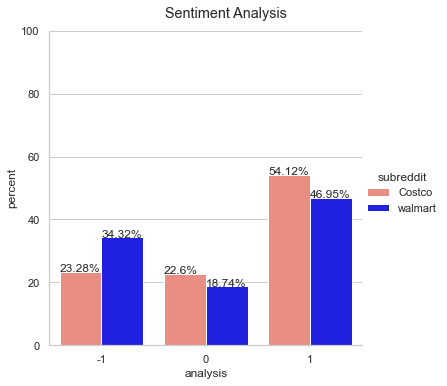

In [58]:
#Sentiment Analysis result group by Subreddit (with count normalization)
sns.set(style="whitegrid")
#sns.set_palette("pastel")

category_order= ['walmart', 'Costco']
x,y = 'analysis', 'subreddit'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, palette=sns.color_palette(['salmon', 'blue']))
#g.figsize(5,5)
g.ax.set_ylim(0,100)
g.fig.suptitle("Sentiment Analysis", y=1.03)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

### Comments:
There are more negative sendiments on Walmart's subreddit posts are double compared to Costco.
- For the sentiments of subreddit post of walmart, 19% are neutral, 34% negative & 47% positive.
- For the sentiments of subreddit post of costco, 22% are neutral, 23% negative & 54% positive.

We would conclude that Walmart's social media image on reddit is not ideal given the numerous posts by Walmart's employees complaining about their workplace environment and conditions. Also supported by the sentiment analysis in which we seek to classify text as having positive or negative emotion.
Costco's social media image on the other hand fared well. Costco seems to be able to offer products and services that customers are interested in and had gone on reddit to discuss and give praises about it.

Let's take a closer look at what the detailed negative feedback from Walmart posts.

In [59]:
# import top 50 words from part 2- result 
data_path = "../datasets/02_Exploratory_Data_Analysis_and_Preprocessing/"

df_walmart_20 = pd.read_csv(data_path + "walmart_top20_words.csv")
df_costco_20  = pd.read_csv(data_path + "costco_top20_words.csv")

In [60]:
df_walmart_20.columns=['Top_words', "count_of_words"]
df_costco_20.columns =['Top_words', "count_of_words"]

In [61]:
df_walmart_20

,Top_words,count_of_words
0,team lead,162
1,store manager,56
2,covid leave,49
3,return work,27
4,people lead,24
5,meat produce,22
6,hour shift,22
7,covid vaccine,21
8,week ago,20
9,key date,20


In [62]:
pd.options.display.max_colwidth = 200

searchfor = ["team lead","store manager","people lead", "return work"]
df[df['text'].str.contains('|'.join(searchfor))][['text','analysis']]

,text,analysis
1,cap overnight team lead due unforseen circumstance wa not able apply for food and consumables originally planned kind glad this point because overnight and cap spot ha opened and staffing ha gotte...,1
5,frustrated and haven been given the raise backpay they promised almost month need some advice there quite bit unpack and talking management ha walked circle start off began transfer right before o...,1
12,teaming okay like job when can get around and stick being team lead also involves being over your department and the store whole fine time most day time frustrating walking with plan which get rui...,1
17,moving different area team lead over area and another area open isn that just move management can make why would they want interview already team lead,0
36,how quit short notice context given post preface this this first job still learning how stuff been working walmart since october but toward the end last month something came and now have move diff...,1
...,...,...
1415,there way cashier can still give employee their discount without the card started november and still haven gotten discount card told people lead and she just ha reapply for new card every time and...,1
1420,didn receive myshare bonus wondering anyone can help with advice maybe manager people lead could help got two point and half point the other day that wa incorrectly given call off for vaccine side...,-1
1660,typical get survey specific employee after going the return desk have returned four thing the past month and each time get nice letter from the store manager with self address stamped envelope ask...,1
1668,super afraid having membership revoked due out portable ac failing and needing returned had terrible luck purchased four portable ac from costco over the last nine year and three them were defecti...,-1


In [63]:
df[df['text'].str.contains('|'.join(searchfor))]['analysis'].value_counts(normalize=True)

 1    0.541667
-1    0.369048
 0    0.089286
Name: analysis, dtype: float64

In [74]:
df.iloc[1420][['text','analysis']]

text        didn receive myshare bonus wondering anyone can help with advice maybe manager people lead could help got two point and half point the other day that wa incorrectly given call off for vaccine side...
analysis                                                                                                                                                                                                         -1
Name: 1420, dtype: object

### Conclusion & Recommendations:

Using the Logistic Regression and TF-IDF Vectorizer as our production classification model, the 85% accuracy and AUC score of 0.93 suggests that most of the posts are accurately classified into its respective subreddits.

More Negative sendiments on Walmart's subreddit posts are double compared to Costco.
- For the sentiments of subreddit post of walmart, 19% are neutral, 34% negative & 47% positive.
- For the sentiments of subreddit post of costco, 22% are neutral, 23% negative & 54% positive.

We would conclude that Walmart's social media image on reddit is not ideal given the numerous posts by Walmart's employees complaining about their workplace environment and conditions. Also supported by the sentiment analysis in which we seek to classify text as having positive or negative emotion.

Costco's social media image on the other hand fared well. Costco seems to be able to offer products and services that customers are interested in and had gone on reddit to discuss and give praises about it.

**Recommendations**

* To the __Primary stakeholder: Walmart Corporate-Empoyees__ (Because happy employees make happy customers, leading to positive improvements to Walmart’s brand image)

    - Provide more benefits programmes：
        - Have better employee benefits to attract and retain employees
    - Suggest for Management Uplift：
        - Consider improving overall management strategy to develop a better company culture
    - Improve HR Policies：
        - Uplift Annual leave and PTO policies
        - Capitalise on Whistle Blowing policy to protect employees, for example, Human Resource Team can reinforce the fact that associates are able to report a concern online without their identities being exposed, especially if they have Team Leads and/or Store Managers who are not carrying out the necessary duties
        - To start being pro-active in addressing and taking in feedback of their employees
    - Improve SOP: 
        - Clear guidelines and protocols on how everything should be carried out in Walmart should be communicated clearly by employers to employees

* To the __Secondary Stakeholder: Walmart Consumers__(Because happy customers keep us going everyday)

    - Promotions：
        - To have better cash rebate scheme and offer better deals, more sales to attract customers
    - House Brands：
        - To develop a House Brand similar to Costco's Kirkland Signature to increase brand loyalty
    - Improve HR Policies：
        - Uplift Annual leave and PTO policies. Capitalise on Whistle Blowing policy to protect employees, for example, Human Resource Team can reinforce the fact that associates are able to report a concern online without their identities being exposed, especially if they have Team Leads and/or Store Managers who are not carrying out the necessary duties
    - Inhouse Foodcout/Food Stations: 
        - Setup a "happy" shopping with "eating" enviroment, potentially develop "hot food" stations or food courts that consumers can enjoy the full experience of shopping in Walmart

## 6. Future Steps

- In the future, a larger dataset could be gathered. Currently, only around 1490 unique posts were gathered for Costco and 1497 posts for Walmart. A larger dataset would be better for us to make inference of the population. 
- More models could be applied, for example models such as artificial neural network could be explored in the future. The advanced models which might provide better predicitions. 
- We are now is comparing Costco Posts, We could compare more subreddit posts of supermarkets in USA to Walmart (Eg. Trader Joe's, Aldi etc.) 
- Our model is limited to just look into the title & selftext of each subreddit post, we can also look into the comments and upvotes in each post.